# FEMU Introduction
J. Réthoré / R. Seghir, 01/2021

We start with a simple example that can be computed without using FEM......
This is a simple plate under uniaxial tension. The problem definition is the following:
- the plate's dimension are $L$, $h$ and $e$ along $\textbf{x}$, $\textbf{y}$, and $\textbf{z}$ direction respectively
- the loading is a force applied on the $x=L$ edge along the $\textbf{x}$ direction
- the $\textbf{x}$ displacement is fixed on the $x=0$ edge
- the $\textbf{y}$ displacement is 0 at the lower left corner $ (x,y)=(0,0)$
- the material is supposed to be isotropic with a linear elastic behaviour
- the coefficients defining this behaviour are the Young modulus $E$ and the Poisson ratio $\nu$

Under these assumptions, an analytical solution can be obtained. The displacement solution is 
- $u_x=\frac{F}{Ehe}x$
- $u_y=-\nu\frac{F}{Ehe}y$

The following steps will be followed:
- first the analytical solution with the reference material parameters is computed. 
- then the sensitivity of this solution to the material parameters is computed together with the covariance matrix of FEMU
- then a FEMU is performed to retrieve the material parameters of the reference solution from a given initial guess


In [12]:
# Chargement des librairies
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage

In [13]:
# geometry
L = 5e-2
h = 1e-2
e = 1e-3
dx=0.01*L
stdu=L/1000/10
# material parameters
E = 210.e9
nu = 0.3

# loading
F = 2.5e3
print('Corresponding axial strain' , F/(e*h)/E)
print('Maximum axial displacement', F/(e*h)/E*L, ' m')
print('Standard deviation of the displacement noise' , stdu, ' m')

Corresponding axial strain 0.0011904761904761904
Maximum axial displacement 5.9523809523809524e-05  m
Standard deviation of the displacement noise 5e-06  m


## Reference solution 

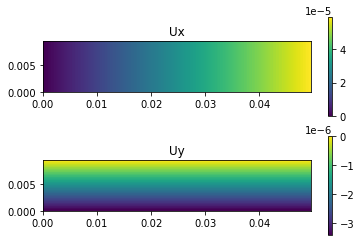

In [14]:
# point coordinates
xm,ym = np.meshgrid(np.arange(0,L,dx),np.arange(0,h,dx))
sizeim = np.shape(xm)


uxm = F/(h*e)/E*xm
uym = -nu*F/(h*e)/E*ym


plt.subplot(211)
plt.imshow(uxm, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('Ux')
plt.colorbar()
plt.subplot(212)
plt.imshow(uym, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('Uy')
plt.colorbar();

## Sensitivity
From this analytical solution, it is possible to compute the sensitivity of the displacement with respect to the material parameters, *i.e.* the derivative of the displacement with respect to the material parameters:
- $\frac{\partial u_x}{\partial E}=-\frac{F}{E^2he}x$
- $\frac{\partial u_y}{\partial E}=\nu\frac{F}{E^2he}y$
- $\frac{\partial u_x}{\partial \nu}=0$
- $\frac{\partial u_y}{\partial \nu}=-\frac{F}{Ehe}y$

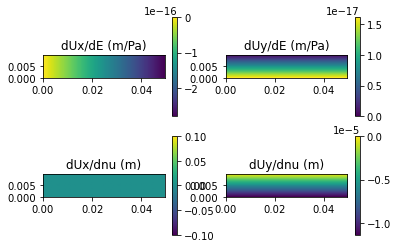

In [15]:
#sensitivity fields
duxdE = -F/(h*e)/pow(E,2)*xm
duydE = nu*F/(h*e)/pow(E,2)*ym
duxdnu = 0*xm
duydnu = -F/(h*e)/E*ym

plt.subplot(221)
plt.imshow(duxdE, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('dUx/dE (m/Pa)')
plt.colorbar()
plt.subplot(222)
plt.imshow(duydE, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('dUy/dE (m/Pa)')
plt.colorbar()
plt.subplot(223)
plt.imshow(duxdnu, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('dUx/dnu (m)')
plt.colorbar()
plt.subplot(224)
plt.imshow(duydnu, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('dUy/dnu (m)')
plt.colorbar()


## FEMU 
The cost function

$\phi(\textbf{P})=\int ||\textbf{u}^{DIC}(\textbf{x})-\textbf{u}^{FEM}(\textbf{x},\textbf{P})||^2 \textbf{dx}$

is to be minimized with respect to $\textbf{P}$, a vector collecting the value of the $n_p$ parameters to be identified.

 In the general case the FEM solution depends on $\textbf{P}$ is not linear. An iterative searched is initiated from an initial guess of the parameters value.
At iteration $iter$, a solution increment $\textbf{dP}=\textbf{P}-\textbf{P}_o$ is searched for, $\textbf{P}_o$ being the solution at the previous iteration.

A linearization of the problem is adopted:

$\textbf{u}^{FEM}(\textbf{x},\textbf{P})=\textbf{u}^{FEM}(\textbf{x},\textbf{P}_o+\textbf{dP})=\textbf{u}^{FEM}(\textbf{x},\textbf{P}_o)
+\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o)\;\textbf{dP}$

The derivatives of the displacement with respect to the parameters is called the sensitivity. Then we obtain for the cost function

$\phi(\textbf{P}_o+\textbf{dP})=\int ||\textbf{u}^{DIC}(\textbf{x})-\textbf{u}^{FEM}(\textbf{x},\textbf{P}_o)
-\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o)\;\textbf{dP}||^2 \textbf{dx}$

Developing the square one gets

$\phi(\textbf{P}_o+\textbf{dP})=
\int ||\textbf{u}^{DIC}(\textbf{x})-\textbf{u}^{FEM}(\textbf{x},\textbf{P}_o)||^2 \textbf{dx}
\;\; - 2\;\;  \int (\textbf{u}^{DIC}(\textbf{x})-\textbf{u}^{FEM}(\textbf{x},\textbf{P}_o)) . \frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o) \textbf{dx} \;\;\textbf{dP}
\;\; + \;\; \textbf{dP}^T \int (\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o))^T  . (\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o)) \textbf{dx} \;\;\textbf{dP}$

Then the stationnarity of the cost function with respect to  is searched for

$\frac{\partial \phi}{\partial P} = 0 \rightarrow 
\int (\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o))^T . (\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o)) \textbf{dx} \;\;\textbf{dP}
=  \int (\textbf{u}^{DIC}(\textbf{x})-\textbf{u}^{FEM}(\textbf{x},\textbf{P}_o)) . \frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}(\textbf{x},\textbf{P}_o) \textbf{dx}$

This procedure is repeated until convergence is reached $i.e.$ $\textbf{dP}$ is small.

## Numerical integration
In pratice the integration over the plate is performed using a discrete sum over sampling points (the number of points is $n$). Each of these points has a weight $w$ that is the areea of the plate divided by the number of points: $w=(h*L)/n$. 

The values of the displacement are then collected in matrices having $n$ lines and 2 columns:
$\textbf{U} = \begin{bmatrix} u_x^1,u_y^1\\-\\ \vdots \\ - \\u_x^n,u_y^n\end{bmatrix}_{(n, 2)}$.

The third dimension refers to the parameters. This means that the sensitivity $\frac{\partial \textbf{u}^{FEM}}{\partial\textbf{P}}$ 
recasts as a matrix with 3 indices refering to the point id, the component and the parameters:

$(\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{i,j,k}= \frac{\partial u_j^{FEM}}{\partial P_k}(\textbf{x}_i)$

Then the system of $n_p$ equations indexed by $i$ resulting from the stationarity condition of the cost function is

$\sum_{p=1}^{n} \sum_{c=1}^2 \sum_{j=1}^{n_p}  \frac{\partial u_c^{FEM}}{\partial P_i}(\textbf{x}_p) \frac{\partial u_c^{FEM}}{\partial P_j}(\textbf{x}_p) w  dP_j = 
\sum_{p=1}^{n} \sum_{c=1}^2 \frac{\partial u_c^{FEM}}{\partial P_i}(\textbf{x}_p) (u_c^{DIC}(\textbf{x}_p)-u_c^{FEM}(\textbf{x}_p)) w$

Using the above defined matrices, we have

$\sum_{p=1}^{n} \sum_{c=1}^2 \sum_{j=1}^{n_p} (\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{p,c,i} (\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{p,c,j}  w dP_j = 
\sum_{p=1}^{n} \sum_{c=1}^2 (\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{p,c,i}(U_{p,c}^{DIC}-U_{p,c}^{FEM}) w$

This can be written in a compact form $\textbf{C}\textbf{dP}=  \textbf{b}$ with

$C_{ij}= \sum_{p=1}^{n} \sum_{c=1}^2 (\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{p,c,i} (\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{p,c,j} w
\;\; , \;\; b_i=\sum_{p=1}^{n} \sum_{c=1}^2 (\frac{\partial \textbf{U}^{FEM}}{\partial\textbf{P}})_{p,c,i}(U_{p,c}^{DIC}-U_{p,c}^{FEM})w$

$\textbf{C}$ is called the covariance matrix.


## Computation of the covariance matrix

In [16]:
#covariance matrix 
x = np.reshape(xm,sizeim[0]*sizeim[1],order='F')
y = np.reshape(ym,sizeim[0]*sizeim[1],order='F')

u=np.array([F/(h*e)/(E)*x,-(nu)*F/(h*e)/(E)*y]).T
dudp=np.array([[-F/(h*e)/pow(E,2)*x,nu*F/(h*e)/pow(E,2)*y],[0*x,-F/(h*e)/E*y]]).T
w=L*h/np.shape(x)[0]


def covariance(dudp,w):
    import numpy as np
    C = np.zeros((np.size(dudp,2),np.size(dudp,2)))
    for ii in range(np.size(dudp,2)):
        for jj in range(np.size(dudp,2)):
            for cc in range(np.size(dudp,1)):
                for pp in range(np.size(dudp,0)):
                    C[ii][jj]=C[ii][jj]+(dudp[pp,cc,ii]*dudp[pp,cc,jj])*w
    return C

C=covariance(dudp,w)

print('C = \n', C)



C = 
 [[ 1.32348043e-35 -3.12550615e-26]
 [-3.12550615e-26  2.18785431e-14]]


## Remark

- *Conditioning ?*
- *Units ?*

In [17]:
# compute the eigen values
eigVal,eigVec = np.linalg.eig(C)
print('Eigen values of C = \n', eigVal)

Eigen values of C = 
 [0.00000000e+00 2.18785431e-14]


## Test case

FEMU is run adding a noise to the reference solution computed earlier to simulate DIC and starting from parameters different from those used for the reference solution $(E_o,\nu_o)$. 
Due to the problem mentioned above, what is actually searched for are multiplying coefficients to the initial values of the parameters. This means that the value for the Young modulus for the current iteration
is $E_o * P(0)$.

dP = 
 [0.04682469 0.28908238]
dP = 
 [0.00229522 0.01353619]
dP = 
 [5.04341569e-06 6.63506823e-04]
dP = 
 [2.4245485e-11 1.4579626e-06]
dP = 
 [-1.54378821e-16  7.00861265e-12]
C  [[ 5.30613048e-13 -1.30555559e-15]
 [-1.30555559e-15  1.36969094e-15]]
Eigen values of C = 
 [5.30616268e-13 1.36647037e-15]
E identif 209824990083.50272  nu identif 0.3258208835985342
relative errors on E 0.0008333805547489711  on nu -0.08606961199511395


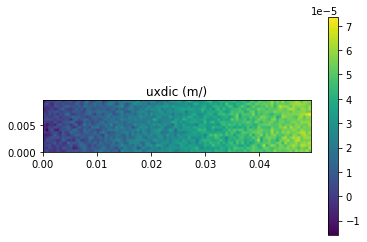

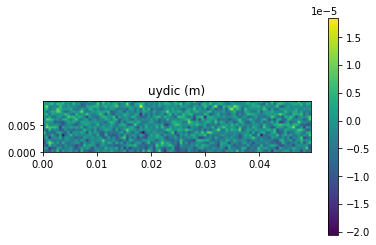

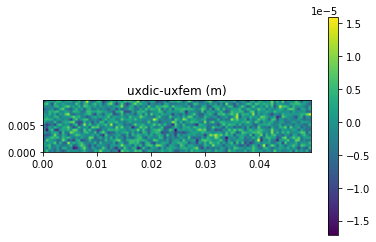

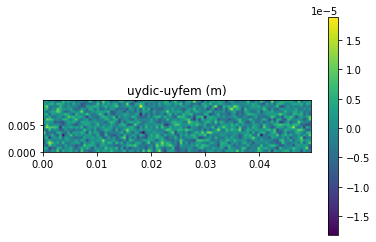

In [18]:
# initial material parameters
Eo = 200.e9
nuo = 0.25
du=1*stdu*np.random.randn(x.shape[0],2)
udic=u+du
P= np.array([1. ,1.])
b= np.array([0. ,0.])

def sensitivity(x,y,S,E,nu,P):
    import numpy as np
    u=np.array([S/(E*P[0])*x,-(nu*P[1])*S/(E*P[0])*y]).T
    dudp=np.array([[-S/E/pow(P[0],2)*x,nu*S/E/pow(P[0],2)*y],
                   [0*x,-nu*S/(E*P[0])*y]]).T
    return (u, dudp)

def residual(dudp,r,w):
    import numpy as np
    b = np.zeros((np.size(dudp,2)))
    for ii in range(np.size(dudp,2)):
        for cc in range(np.size(dudp,1)):
            for pp in range(np.size(u,0)):
                b[ii]=b[ii]+(dudp[pp,cc,ii]*r[pp,cc])*w
    return b
iter=0

while (iter < 5):
    (ui,dudpi)= sensitivity(x,y,F/(h*e),Eo,nuo,P)
    C=covariance(dudpi,w)

    Cinv=np.linalg.inv(C)
    #print('Ci = \n',Cinv)
    b=residual(dudpi,udic-ui,w)
    #print('b  = \n',b)
 
    dP=np.dot(Cinv,b)
    print('dP = \n',dP)
    P=P+dP
    #print('P = \n',P)
    iter=iter+1
print('C ' ,C)
eigVal,eigVec = np.linalg.eig(C)
print('Eigen values of C = \n', eigVal)
Ei=Eo*P[0]
nui=nuo*P[1]
print('E identif' , Ei,' nu identif', nui)
print('relative errors on E', (E-Ei)/E, ' on nu', (nu-nui)/nu)

uxdic= np.reshape(udic[:,0],[sizeim[0],sizeim[1]],order='F')
uydic= np.reshape(udic[:,1],[sizeim[0],sizeim[1]],order='F')
uxfem= np.reshape(ui[:,0],[sizeim[0],sizeim[1]],order='F')
uyfem= np.reshape(ui[:,1],[sizeim[0],sizeim[1]],order='F')

#plt.subplot(411)
ff = plt.figure()
plt.imshow(uxdic, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('uxdic (m/)')
plt.colorbar()
#plt.subplot(412)
ff = plt.figure()
plt.imshow(uydic, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('uydic (m)')
plt.colorbar()
#plt.subplot(413)
ff = plt.figure()
plt.imshow(uxdic-uxfem, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('uxdic-uxfem (m)')
plt.colorbar()
#plt.subplot(414)
ff = plt.figure()
plt.imshow(uydic-uyfem, extent=(np.amin(xm), np.amax(xm), np.amin(ym), np.amax(ym)), aspect = 'equal')
plt.title('uydic-uyfem (m)')
plt.colorbar();



## Remarks
- *Conditioning ?*: much better with the relative identification strategy
- *Accuracy ?* 
- *Robustness ? *
- The covariance matrix usually depand on the material parameters, and should be updated

## Alternative resolution strategy

In the previous cell a *full* Gauss-Newton algorithm is used. Alernatively, a fixed point or staggered algorithm could be used. 
This somehow simply consists in 'lumping' the covariance matrix, *i.e.* neglecting the coupling terms. 

As aconsequence, at each iteration the parameters increments are obtained *explicitly*:

$\textbf{C}_{ii}\textbf{dP}_i=  \textbf{b}_i$





In [19]:
P= np.array([1. ,1.])
dP= np.array([0. ,0.])
iter=0
while (iter < 5):
    (ui,dudpi)= sensitivity(x,y,F/(h*e),Eo,nuo,P)
    C=covariance(dudpi,w)

    #print('Ci = \n',Cinv)
    b=residual(dudpi,udic-ui,w)
    #print('b  = \n',b)
    for ii in range(np.size(dudp,2)):
        dP[ii]=b[ii]/C[ii,ii]
    print('dP = \n',dP)
    P=P+dP
    #print('P = \n',P)
    iter=iter+1
Ei=Eo*P[0]
nui=nuo*P[1]
print('E identif' , Ei,' nu identif', nui)
print('relative errors on E', (E-Ei)/E, ' on nu', (nu-nui)/nu)



dP = 
 [0.04614672 0.24225769]
dP = 
 [0.00282216 0.05732611]
dP = 
 [0.00014705 0.00350586]
dP = 
 [8.54324983e-06 1.82679043e-04]
dP = 
 [4.43472234e-07 1.06129178e-05]
E identif 209824984640.14014  nu identif 0.3258207374192624
relative errors on E 0.0008334064755231585  on nu -0.08606912473087462


The main difference is on the convergence speed on such a *simple* problem. For more complex constitutive law to identify it may cause additionnal difficulties. 

## Reformulation for improving conditioning

The conditioning problem mentionned earlier are due to:
- the Young modulus is a denominator
- Young modulus and Poisson ratio don't have the same unit
To improve the conditioning, the Hooke law

$\epsilon = \frac{1+\nu}{E} \sigma -\frac{\nu}{E} \text{tr}(\sigma$)

is parametrized a bit differently. Instead of identifying $(E,\nu)$ as intrinsic parameters, one can try to identify $(\frac{1+\nu}{E},\frac{\nu}{E})$.


In [20]:
P= np.array([(1.+nuo)/Eo ,nuo/Eo])
b= np.array([0. ,0.])

def sensitivity2(x,y,S,E,nu,P):
    import numpy as np
    u=np.array([S*(P[0]-P[1])*x,-(P[1])*S*y]).T
    dudp=np.array([[S*x,0*y],[-S*x,-S*y]]).T
    return (u, dudp)


iter=0

while (iter < 5):
    (ui,dudpi)= sensitivity2(x,y,F/(h*e),Eo,nuo,P)
    C=covariance(dudpi,w)

    Cinv=np.linalg.inv(C)
    #print('Ci = \n',Cinv)
    b=residual(dudpi,udic-ui,w)
    #print('b  = \n',b)
 
    dP=np.dot(Cinv,b)
    print('dP = \n',dP)
    P=P+dP
    #print('P = \n',P)
    iter=iter+1
print('C ' ,C)

eigVal,eigVec = np.linalg.eig(C)
print('Eigen values of C = \n', eigVal)
Ei=1/(P[0]-P[1])
nui=(P[1])*Ei
#Ei=1/((1+nuo)/Eo*P[0]-nuo/Eo*P[1])
#nui=(nuo/Eo*P[1])*Ei
print('E identif' , Ei,' nu identif', nui)
print('relative errors on E', (E-Ei)/E, ' on nu', (nu-nui)/nu)


dP = 
 [6.86986596e-14 3.02822109e-13]
dP = 
 [6.15621556e-27 6.29978525e-27]
dP = 
 [-1.98657703e-28 -5.50880051e-29]
dP = 
 [-1.98657703e-28 -5.50880051e-29]
dP = 
 [-1.98657703e-28 -5.50880051e-29]
C  [[ 2.56523438e+10 -2.56523438e+10]
 [-2.56523438e+10  2.66171875e+10]]
Eigen values of C = 
 [4.77886026e+08 5.17916452e+10]
E identif 209824990083.50272  nu identif 0.3258208835985342
relative errors on E 0.0008333805547489711  on nu -0.08606961199511395


- The conditioning is improved in the same way as when using the relative strategy. 
- A good parametrization is one of the key

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=358c2e45-dae9-4a73-945e-41a0a75fc23d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>